<a href="https://colab.research.google.com/github/balladembelemoussa/codesandbox-template-nuxt/blob/main/Histogramme_de_s%C3%A9rie_chronologique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Histogramme de série chronologique 
Cet exemple montre comment visualiser efficacement un grand nombre de séries chronologiques d'une manière qui pourrait potentiellement révéler une sous-structure et des modèles cachés qui ne sont pas immédiatement évidents, et les afficher de manière visuellement attrayante.

Dans cet exemple, nous générons plusieurs séries de « signaux » sinusoïdaux qui sont enfouies sous un plus grand nombre de séries de « bruit/fond » de marche aléatoire. Pour une marche aléatoire gaussienne non biaisée avec un écart type de σ, l'écart RMS par rapport à l'origine après n étapes est σ*sqrt(n). Ainsi, afin de garder les sinusoïdes visibles à la même échelle que les marches aléatoires, nous mettons à l'échelle l'amplitude par la marche aléatoire RMS. De plus, nous introduisons également un petit décalage aléatoire phi pour décaler les sinus vers la gauche/droite, et un bruit aléatoire additif pour décaler les points de données individuels vers le haut/vers le bas pour rendre le signal un peu plus "réaliste" (vous ne vous attendriez pas à un sinus parfait wave à apparaître dans vos données).

Le premier graphique montre la manière typique de visualiser plusieurs séries chronologiques en les superposant les unes sur les autres avec plt.plotet une petite valeur de alpha. Les deuxième et troisième graphiques montrent comment réinterpréter les données sous la forme d'un histogramme 2D, avec une interpolation facultative entre les points de données, en utilisant np.histogram2det plt.pcolormesh.

0.362 sec. elapsed
0.126 sec. elapsed


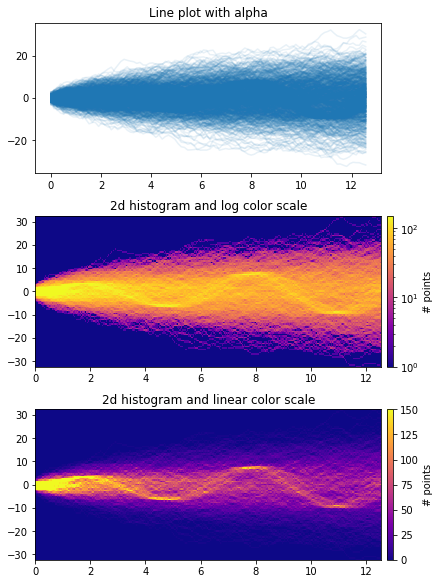

In [7]:
from copy import copy
import time

import numpy as np
import numpy.matlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

fig, axes = plt.subplots(nrows=3, figsize=(6, 8), constrained_layout=True)

# Make some data; a 1D random walk + small fraction of sine waves
num_series = 1000
num_points = 100
SNR = 0.10  # Signal to Noise Ratio
x = np.linspace(0, 4 * np.pi, num_points)
# Generate unbiased Gaussian random walks
Y = np.cumsum(np.random.randn(num_series, num_points), axis=-1)
# Generate sinusoidal signals
num_signal = int(round(SNR * num_series))
phi = (np.pi / 8) * np.random.randn(num_signal, 1)  # small random offset
Y[-num_signal:] = (
    np.sqrt(np.arange(num_points))[None, :]  # random walk RMS scaling factor
    * (np.sin(x[None, :] - phi)
       + 0.05 * np.random.randn(num_signal, num_points))  # small random noise
)


# Plot series using `plot` and a small value of `alpha`. With this view it is
# very difficult to observe the sinusoidal behavior because of how many
# overlapping series there are. It also takes a bit of time to run because so
# many individual artists need to be generated.
tic = time.time()
axes[0].plot(x, Y.T, color="C0", alpha=0.1)
toc = time.time()
axes[0].set_title("Line plot with alpha")
print(f"{toc-tic:.3f} sec. elapsed")


# Now we will convert the multiple time series into a histogram. Not only will
# the hidden signal be more visible, but it is also a much quicker procedure.
tic = time.time()
# Linearly interpolate between the points in each time series
num_fine = 800
x_fine = np.linspace(x.min(), x.max(), num_fine)
y_fine = np.empty((num_series, num_fine), dtype=float)
for i in range(num_series):
    y_fine[i, :] = np.interp(x_fine, x, Y[i, :])
y_fine = y_fine.flatten()
x_fine = np.matlib.repmat(x_fine, num_series, 1).flatten()


# Plot (x, y) points in 2d histogram with log colorscale
# It is pretty evident that there is some kind of structure under the noise
# You can tune vmax to make signal more visible
cmap = copy(plt.cm.plasma)
cmap.set_bad(cmap(0))
h, xedges, yedges = np.histogram2d(x_fine, y_fine, bins=[400, 100])
pcm = axes[1].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         norm=LogNorm(vmax=1.5e2), rasterized=True)
fig.colorbar(pcm, ax=axes[1], label="# points", pad=0)
axes[1].set_title("2d histogram and log color scale")

# Same data but on linear color scale
pcm = axes[2].pcolormesh(xedges, yedges, h.T, cmap=cmap,
                         vmax=1.5e2, rasterized=True)
fig.colorbar(pcm, ax=axes[2], label="# points", pad=0)
axes[2].set_title("2d histogram and linear color scale")

toc = time.time()
print(f"{toc-tic:.3f} sec. elapsed")
plt.show()